In [1]:
import pandas as pd
from gamescout_db import db, cur
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
import numpy as np
import math
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [2]:
COLUMNS = ['HITS','1_AGO_AVG', '2_AGO_AVG', '3_AGO_AVG', '4_AGO_AVG', '5_AGO_AVG', '6_AGO_AVG','7_AGO_AVG', 
           '8_AGO_AVG', '9_AGO_AVG', '10_AGO_AVG','11_AGO_AVG', '12_AGO_AVG', '13_AGO_AVG', '14_AGO_AVG', 
           '15_AGO_AVG']

In [3]:
data = pd.read_sql('select * from BatterStats;', con=db)

data["GOT_HIT"] = [1 if x > 0 else 0 for x in data["HITS"]]
data["NOT_HIT"] = [1 if x == 0 else 1 for x in data["HITS"]]

data = data.dropna() #apply(pd.to_numeric, errors="ignore")

In [4]:
y = data["GOT_HIT"]
x = data[['1_AGO_AVG', '2_AGO_AVG', '3_AGO_AVG', '4_AGO_AVG', '5_AGO_AVG', '6_AGO_AVG','7_AGO_AVG', '8_AGO_AVG', 
          '9_AGO_AVG', '10_AGO_AVG', '11_AGO_AVG', '12_AGO_AVG', '13_AGO_AVG', '14_AGO_AVG', '15_AGO_AVG']]
x.head()

,1_AGO_AVG,2_AGO_AVG,3_AGO_AVG,4_AGO_AVG,5_AGO_AVG,6_AGO_AVG,7_AGO_AVG,8_AGO_AVG,9_AGO_AVG,10_AGO_AVG,11_AGO_AVG,12_AGO_AVG,13_AGO_AVG,14_AGO_AVG,15_AGO_AVG
7548,0.500000,0.750000,0.50,0.000000,0.333333,0.000000,0.5,0.400000,0.25,0.500000,0.666667,1.00,0.333333,0.20,0.00
7898,0.000000,0.166667,0.60,0.400000,0.500000,0.200000,0.5,0.000000,0.60,0.333333,0.250000,0.00,0.500000,0.25,1.00
7899,0.250000,0.200000,0.00,0.333333,0.000000,0.250000,0.0,0.400000,0.00,0.250000,0.250000,0.50,0.000000,0.00,0.25
7934,0.333333,0.200000,0.25,0.200000,0.000000,0.000000,0.4,0.400000,0.00,0.000000,0.250000,0.25,0.666667,0.75,0.75
7996,0.200000,0.250000,0.25,0.666667,0.000000,0.333333,0.5,0.333333,0.60,0.333333,0.000000,0.00,0.000000,0.00,0.25


In [5]:
len(x)

144543

In [6]:
train_x = x[:110000]
test_x = x[110001:]

train_y = y[:110000]
test_y = y[110001:]

model = linear_model.LogisticRegression(class_weight='balanced')
model.fit(train_x, train_y)

model.coef_

array([[ 0.27450486,  0.17103172,  0.16340166,  0.12950665,  0.1201322 ,
         0.13259823,  0.16066355,  0.13198527,  0.1607471 ,  0.12122768,
         0.13749373,  0.13000809,  0.10865749,  0.11443541,  0.11117684]])

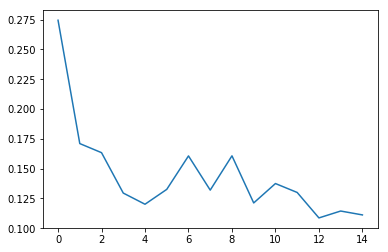

In [14]:
plt.plot(model.coef_[0])

(array([    21.,    195.,   1142.,   3935.,   8079.,  10139.,   7348.,
          2920.,    688.,     75.]),
 array([ 0.34179155,  0.37108213,  0.40037271,  0.42966329,  0.45895387,
         0.48824444,  0.51753502,  0.5468256 ,  0.57611618,  0.60540676,
         0.63469734]),
 <a list of 10 Patch objects>)

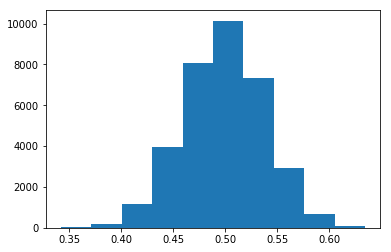

In [7]:
plt.hist(model.predict_proba(test_x)[:,0])

In [8]:
predicted = model.predict(test_x)
expected = test_y
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

             precision    recall  f1-score   support

          0       0.42      0.54      0.47     13424
          1       0.65      0.54      0.59     21118

avg / total       0.56      0.54      0.54     34542

[[ 7190  6234]
 [ 9742 11376]]


In [15]:
probs = model.predict_proba(test_x)[:,1]
pairs = zip(expected, probs)

In [16]:
prob_bins = {}
x = np.array([probs])
bins = np.linspace(0, 1, num=101)

inds = np.digitize(x, bins)

for i, pair in enumerate(pairs):
    key = str(inds[0][i] - 1)
    
    if key not in prob_bins:
        #print(key)
        prob_bins[key] = []
        
    prob_bins[key].append(pair)

In [17]:
pct_hit = []
for key in sorted(prob_bins.keys()):
    hits = [sum(x) for x in zip(*prob_bins[str(key)])][0]
    total = len(prob_bins[str(key)])
    pct = float(hits)/float(total)
    pct_hit.append(pct)

    print("Key: " + str(key))
    print("Num Hits: " + str(hits))
    print("Tot player in bin: " + str(total))
    print("Pct. Hit: " + str(float(hits)/float(total)))
    print("")

Key: 36
Num Hits: 0
Tot player in bin: 2
Pct. Hit: 0.0

Key: 37
Num Hits: 4
Tot player in bin: 9
Pct. Hit: 0.444444444444

Key: 38
Num Hits: 9
Tot player in bin: 27
Pct. Hit: 0.333333333333

Key: 39
Num Hits: 26
Tot player in bin: 86
Pct. Hit: 0.302325581395

Key: 40
Num Hits: 63
Tot player in bin: 161
Pct. Hit: 0.391304347826

Key: 41
Num Hits: 144
Tot player in bin: 307
Pct. Hit: 0.469055374593

Key: 42
Num Hits: 239
Tot player in bin: 507
Pct. Hit: 0.471400394477

Key: 43
Num Hits: 438
Tot player in bin: 817
Pct. Hit: 0.536107711138

Key: 44
Num Hits: 668
Tot player in bin: 1264
Pct. Hit: 0.528481012658

Key: 45
Num Hits: 979
Tot player in bin: 1781
Pct. Hit: 0.549691184728

Key: 46
Num Hits: 1425
Tot player in bin: 2412
Pct. Hit: 0.5907960199

Key: 47
Num Hits: 1738
Tot player in bin: 2928
Pct. Hit: 0.593579234973

Key: 48
Num Hits: 1924
Tot player in bin: 3205
Pct. Hit: 0.60031201248

Key: 49
Num Hits: 2085
Tot player in bin: 3426
Pct. Hit: 0.608581436077

Key: 50
Num Hits: 2314
T

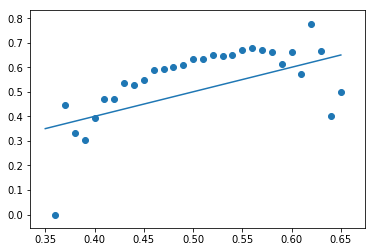

In [22]:
plt.scatter(sorted([float(i)/100 for i in prob_bins.keys()]),pct_hit)
plt.plot([0.35, 0.65], [0.35, 0.65], "-")